# Monografía Final
## Redes Neuronales - FIUBA
### Alumno: Julián Stejman

En este documento se utilizará una red neuronal entrenada con un algoritmo de aprendizaje por refuerzo PPO (Proximal Policy Optimization) que aprendiese a jugar niveles de Super Mario Bros para la NES. Para ello, se utilizará el entorno de OpenAI Gym, que simula el juego de Super Mario Bros, junto con LSTM para capturar dependencias temporales.

In [1]:
%pip install gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY
import torch
import torch.nn as nn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.3 MB/s eta 0:00:00
  Created wheel for nes-py: filename=nes_py-8.2.1-cp310-cp310-linux_x86_64.whl size=535720 sha256=a8496fb16369b52348fb4c0d32ba3e7ed40318eb0347b67bb3281588ef1163f4
  Stored in directory: /root/.cache/pip/wheels/34/a7/d5/9aa14b15df740a53d41f702e4c795731b6c4da7925deb8476c
Successfully built nes-py
Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Si se eliminara en la siguiente celda la línea que dice %%skip, se podría ver una simulación simple de como funciona el emulador del juego con el entorno. 

In [3]:

%%skip
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

done = True
for step in range(5000):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()

env.close()

La idea sería armar una red neuronal convolucional para poder interpretar de las imágenes recibidas una posible acción para que tomara el personaje del juego. Esta red luego utilizará un algoritmo de aprendizaje por refuerzo para poder mejorar su desempeño.

La arquitectura utiliza una red Actor-Critic que procesa las imágenes del juego a través de capas convolucionales, seguidas por una LSTM para capturar dependencias temporales. El Actor predice la distribución de probabilidades sobre acciones (policy), mientras que el Critic estima el valor esperado del estado para el cálculo del advantage.

In [4]:
class PPOActorCritic(nn.Module):
    def __init__(self, input_shape, num_actions, hidden_size=128):
        super().__init__()
        
        # Capas convolucionales para procesamiento de imágenes
        self.image_processing = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        # Calcular tamaño de salida de las conv
        flatten_size = self._get_flatten_size(input_shape)
        
        # LSTM para dependencias temporales
        self.lstm = nn.LSTM(flatten_size, hidden_size=hidden_size, batch_first=True)
        self.hidden_size = hidden_size
        
        # Capas Actor y Critic
        self.actor = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )
        
        self.critic = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def _get_flatten_size(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            output = self.image_processing(dummy_input)
            return int(output.view(1, -1).size(1))
    
    def forward(self, x, hidden_state=None):
        """
        x: (batch_size, seq_len, channels, height, width)
        hidden_state: (h, c) tuple de LSTM o None
        """
        # Procesar imágenes
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(batch_size * seq_len, *x.shape[2:])
        x = self.image_processing(x)
        x = x.view(batch_size * seq_len, -1)
        x = x.view(batch_size, seq_len, -1)
        
        # LSTM
        if hidden_state is None:
            x, hidden_state = self.lstm(x)
        else:
            x, hidden_state = self.lstm(x, hidden_state)
        
        # Usar solo el último output
        x = x[:, -1, :]
        
        # Actor y Critic
        action_logits = self.actor(x)
        value = self.critic(x)
        
        return action_logits, value, hidden_state

In [5]:
frame_stack_count = 4
dimensions = 84
input_shape = (frame_stack_count, dimensions, dimensions)
num_actions = len(RIGHT_ONLY)

test_model = PPOActorCritic(input_shape, num_actions)
dummy_state = torch.zeros(1, 1, *input_shape)  # (batch_size, seq_len, channels, height, width)
action_logits, value, hidden_state = test_model(dummy_state)
print(f"Action logits shape: {action_logits.shape}")
print(f"Value shape: {value.shape}")
print(f"Number of actions: {num_actions}")

Action logits shape: torch.Size([1, 5])
Value shape: torch.Size([1, 1])
Number of actions: 5


Para enviar a la red, se toma la decisión de mandar los colores a blanco y negro,bajarle la resolución a 84x84 que es la que se suele utilizar para este tipo de ensayos, y de devolver en cada estado 4 cuadros. De esta forma la red podrá aprender en cada estado con más información del entorno y menos en definición visual

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


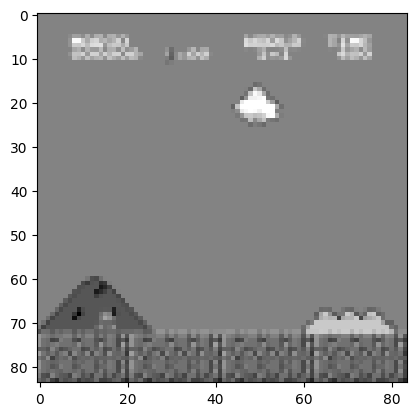

In [6]:
import gym
from gym.wrappers import GrayScaleObservation, FrameStack, ResizeObservation

# Create the Super Mario environment
env = gym.make('SuperMarioBros-v0')

# Apply the wrappers for preprocessing
env = GrayScaleObservation(env, keep_dim=True)  # Convert to grayscale (removes color channels)
env = ResizeObservation(env, shape=(dimensions,dimensions))     # Resize to 84x84
env = FrameStack(env, num_stack=frame_stack_count)               # Stack 4 frames

# Reset the environment to start
state = env.reset()

# Visualize the preprocessed frame (optional)
import matplotlib.pyplot as plt
plt.imshow(state[0], cmap='gray')  # Show the first frame in the stack
plt.show()


Para el entrenamiento con PPO, se utiliza un rollout buffer que acumula experiencias de un episodio completo o de N pasos de interacción. A diferencia de DQN (off-policy), PPO es on-policy: utiliza las experiencias para actualizar la red y luego las descarta, enfocándose en lo más reciente.

In [7]:
from collections import deque
import numpy as np

def preprocess_state(state):
    """
    Preprocesa el estado del juego:
    - Convierte a escala de grises
    - Normaliza entre 0-1
    - Redimensiona a 84x84
    """
    # Hacer copia para evitar problemas con strides negativos
    if isinstance(state, np.ndarray):
        state = state.copy()
    
    state = torch.tensor(state, dtype=torch.float32)
    
    # Si está en RGB (3 canales), convertir a escala de grises
    if len(state.shape) == 3:
        # Media ponderada: luminancia = 0.299*R + 0.587*G + 0.114*B
        state = 0.299 * state[:,:,0] + 0.587 * state[:,:,1] + 0.114 * state[:,:,2]
    
    # Normalizar a [0, 1]
    state = state / 255.0
    
    # Redimensionar a 84x84 si es necesario
    if state.shape != (84, 84):
        import torch.nn.functional as F
        state = F.interpolate(state.unsqueeze(0).unsqueeze(0), size=(84, 84), mode='bilinear', align_corners=False)
        state = state.squeeze(0).squeeze(0)
    
    return state

class CustomFrameStack:
    """
    Mantiene un stack de los últimos k frames.
    Necesario porque LSTM necesita secuencias temporales para capturar dependencias.
    """
    def __init__(self, k=4):
        self.k = k
        self.frames = deque(maxlen=k)
    
    def reset(self, state):
        """Resetea el stack e inicializa con el nuevo estado"""
        state = preprocess_state(state)
        self.frames.clear()
        # Llenar con el mismo frame inicial
        for _ in range(self.k):
            self.frames.append(state)
        return self.get_state()
    
    def push(self, state):
        """Agrega un nuevo frame al stack"""
        state = preprocess_state(state)
        self.frames.append(state)
        return self.get_state()
    
    def get_state(self):
        """Retorna el stack actual como (k, 84, 84)"""
        return torch.stack(list(self.frames))

class RolloutBuffer:
    """
    Buffer on-policy para PPO: almacena experiencias hasta end_episode()
    
    A diferencia de DQN, PPO es on-policy: recolecta experiencias, 
    las usa para actualizar, y luego las descarta.
    """
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []
    
    def push(self, state, action, reward, value, log_prob, done):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        self.log_probs.append(log_prob)
        self.dones.append(done)
    
    def compute_returns_and_advantages(self, gamma=0.99, gae_lambda=0.95):
        """
        Calcula returns y advantages usando Generalized Advantage Estimation (GAE)
        
        GAE mezcla TD de corto plazo con Monte Carlo de largo plazo.
        λ = 0.95 da buen balance entre bias y varianza.
        """
        returns = []
        advantages = []
        gae = 0
        next_value = 0
        
        # Iterar hacia atrás a través de los rewards
        for t in reversed(range(len(self.rewards))):
            if t == len(self.rewards) - 1:
                next_non_terminal = 1.0 - self.dones[t]
                next_value = 0
            else:
                next_non_terminal = 1.0 - self.dones[t]
                next_value = self.values[t + 1]
            
            # δ_t = r_t + γ*V(s_{t+1}) - V(s_t)
            delta = self.rewards[t] + gamma * next_value * next_non_terminal - self.values[t]
            # gae_t = δ_t + (γλ) * gae_{t+1}
            gae = delta + gamma * gae_lambda * next_non_terminal * gae
            
            returns.insert(0, gae + self.values[t])
            advantages.insert(0, gae)
        
        return torch.tensor(returns, dtype=torch.float32), torch.tensor(advantages, dtype=torch.float32)
    
    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []

## Función de Entrenamiento PPO Corregida

### Cambios principales:

**1. FrameStack integrado**
- Ahora sí usamos 4 frames: `(4, 84, 84)` para cada estado
- La LSTM recibe secuencias con información temporal real

**2. Dimensiones correctas**
- Estado individual: `(4, 84, 84)`
- Estado batch: `(batch_size, 1, 4, 84, 84)` donde `1` es la secuencia de longitud 1
- La LSTM procesa esta dimensión de secuencia

**3. Hidden state persistente**
- El `hidden_state` de LSTM se mantiene entre pasos dentro del mismo episodio
- Permite que la LSTM recuerde información del pasado

**4. Mejor logging**
- Mostramos reward del episodio, promedio de últimos 10, y cantidad de pasos
- Checkpoints automáticos cada N episodios

### Flujo del entrenamiento:
```
Para cada episodio:
  1. Recolectar experiencias (rollout)
     - Forward pass en modelo
     - Sample acción y guardar (state, action, reward, log_prob, value)
  2. Calcular returns y advantages con GAE
  3. Normalizar advantages
  4. Para cada época (4 típicamente):
     - Pasar por mini-batches
     - Calcular PPO loss (clipped objective)
     - Actualizar modelo
  5. Guardar checkpoint cada 10 episodios
```

## Entrenamiento PPO

El algoritmo PPO entrena la red actor-critic utilizando rollouts de experiencias recientes. Cada cierto número de steps, se realiza una actualización con múltiples épocas sobre el mismo batch.

In [8]:
def train_ppo(env, model, num_episodes=100, rollout_steps=2048, num_epochs=4,
              batch_size=64, gamma=0.99, gae_lambda=0.95, learning_rate=3e-4,
              clip_ratio=0.2, entropy_coef=0.01, value_coef=0.5,
              device="cpu", checkpoint_freq=10, checkpoint_path="mario_ppo.pt"):
    """
    Entrena PPO en el ambiente SuperMario
    
    El algoritmo:
    1. Recolecta experiencias con la política actual
    2. Calcula advantages usando GAE
    3. Actualiza actor y critic múltiples épocas sobre los mismos datos
    4. Usa clipping de PPO para evitar actualizaciones muy grandes
    """
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    total_rewards = []
    step_count = 0
    
    for episode in range(num_episodes):
        # ========== RECOLECCIÓN DE EXPERIENCIAS ==========
        
        state = env.reset()
        frame_stack = CustomFrameStack(k=4)
        stacked_state = frame_stack.reset(state)
        
        buffer = RolloutBuffer()
        episode_reward = 0
        episode_length = 0
        done = False
        hidden_state = None
        
        print(f"Episodio {episode + 1}/{num_episodes}")
        
        # Variable para reward shaping basado en progreso en X
        prev_x_pos = 40  # Posición inicial aproximada de Mario
        stuck_counter = 0  # Contador de pasos sin avanzar
        
        # Recolectar experiencias para este episodio
        while not done:
            # Convertir estado a batch
            state_batch = stacked_state.unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, 4, 84, 84)
            
            # Forward pass
            with torch.no_grad():
                action_logits, value, hidden_state = model(state_batch, hidden_state)
                probs = torch.softmax(action_logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                
                # Acción muestreada de la política (sin epsilon-greedy, que corrompe los ratios de PPO)
                action = dist.sample()
                log_prob = dist.log_prob(action)
            
            # Interaction with environment - compatible con gym viejo y nuevo
            step_result = env.step(action.item())
            if len(step_result) == 5:  # gym >= 0.26
                next_state, reward, terminated, truncated, info = step_result
                done = terminated or truncated
            else:  # gym < 0.26
                next_state, reward, done, info = step_result
            
            # Reward shaping: Recompensar por avanzar en X
            current_x_pos = info.get('x_pos', prev_x_pos)
            x_progress = current_x_pos - prev_x_pos
            reward = x_progress * 2.0  # Recompensa por avanzar
            
            # Penalización por muerte
            if done and info.get('life', 3) < 3:
                reward -= 50.0
            
            # Detección de estancamiento
            if x_progress <= 0:
                stuck_counter += 1
                if stuck_counter > 100:
                    reward -= 0.5  # Penalización leve por inactividad
                if stuck_counter > 500:
                    done = True  # Cortar episodio si está muy trabado
            else:
                stuck_counter = 0
            
            prev_x_pos = current_x_pos
            
            # Stack frames
            next_stacked_state = frame_stack.push(next_state)
            
            # Store in buffer
            buffer.push(
                stacked_state.cpu().numpy(),  # Estado original (4, 84, 84)
                action.item(),
                reward,
                value.item(),
                log_prob.item(),
                float(done)
            )
            
            episode_reward += reward
            stacked_state = next_stacked_state
            step_count += 1
            episode_length += 1
        
        # ========== CÁLCULO DE RETURNS Y ADVANTAGES ==========
        # Convertir buffer a tensores
        returns, advantages = buffer.compute_returns_and_advantages(gamma, gae_lambda)
        
        # Convertir buffer a tensores
        states_array = np.array(buffer.states)  # (T, 4, 84, 84)
        states_tensor = torch.tensor(states_array, dtype=torch.float32).to(device)
        
        actions_tensor = torch.tensor(buffer.actions, dtype=torch.long).to(device)
        old_log_probs = torch.tensor(buffer.log_probs, dtype=torch.float32).to(device)
        
        # Normalizar advantages (importante para estabilidad)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        advantages = advantages.to(device)
        returns = returns.to(device)
        
        # ========== ACTUALIZACIÓN PPO ==========
        
        num_batches = max(1, len(buffer.states) // batch_size)
        
        for epoch in range(num_epochs):
            # Shuffled minibatch updates
            indices = torch.randperm(len(buffer.states), device=device)
            
            for batch_idx in range(num_batches):
                start_idx = batch_idx * batch_size
                end_idx = min(start_idx + batch_size, len(buffer.states))
                batch_indices = indices[start_idx:end_idx]
                batch_states = states_tensor[batch_indices]  # (B, 4, 84, 84)
                batch_actions = actions_tensor[batch_indices]
                batch_old_log_probs = old_log_probs[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_returns = returns[batch_indices]
                
                # Agregar dimensión de secuencia para LSTM: (B, 1, 4, 84, 84)
                batch_states = batch_states.unsqueeze(1)
                
                # Forward pass
                action_logits, values, _ = model(batch_states)
                
                # Calcular nuevos log probs
                probs = torch.softmax(action_logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                new_log_probs = dist.log_prob(batch_actions)
                entropy = dist.entropy().mean()
                
                # ===== PPO LOSS =====
                # Ratio de probabilidades: π_new / π_old
                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                
                # Clipped objective (PPO's key innovation)
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1.0 - clip_ratio, 1.0 + clip_ratio) * batch_advantages
                actor_loss = -torch.min(surr1, surr2).mean()
                
                # ===== VALUE LOSS =====
                value_loss = ((values.squeeze() - batch_returns) ** 2).mean()
                
                # ===== TOTAL LOSS =====
                # Combinamos: actor loss + value loss - entropy (para exploración)
                total_loss = actor_loss + value_coef * value_loss - entropy_coef * entropy
                
                # Optimization step
                optimizer.zero_grad()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                optimizer.step()
        
        # Agregar reward del episodio a la lista
        total_rewards.append(episode_reward)
        
        # Calcular y mostrar estadísticas
        avg_10 = np.mean(total_rewards[-10:]) if len(total_rewards) >= 10 else np.mean(total_rewards)
        max_reward = max(total_rewards)
        print(f"  Reward: {episode_reward:.1f} | Avg(10): {avg_10:.1f} | Max: {max_reward:.1f} | Steps: {episode_length} | X_pos: {prev_x_pos:.0f}")
        
        # Checkpoint
        if (episode + 1) % checkpoint_freq == 0:
            save_checkpoint(model, total_rewards, checkpoint_path, device)
            print(f"  📊 Progreso: Mejor={max_reward:.1f}, Promedio últimos 10={avg_10:.1f}")
    
    return total_rewards

def save_checkpoint(model, total_rewards, checkpoint_path, device="cpu"):
    """
    Guarda el modelo y training state con torch.save()
    
    torch.save es mejor que pickle:
    - Versión-agnóstico
    - Mejor performance
    - Standard en la comunidad de PyTorch
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'total_rewards': total_rewards,
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"✓ Checkpoint guardado en {checkpoint_path}")

def load_checkpoint(model, checkpoint_path, device="cpu"):
    """
    Carga modelo y training state con torch.load()
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    total_rewards = checkpoint['total_rewards']
    print(f"✓ Checkpoint cargado desde {checkpoint_path}")
    return model, total_rewards

## Preprocesamiento y Frame Stacking

### Preprocesamiento (`preprocess_state`)
Cada frame del juego se procesa:
1. **Conversión a escala de grises**: Reduce de 3 canales (RGB) a 1. Usamos luminancia estándar: `0.299*R + 0.587*G + 0.114*B`
2. **Normalización**: Divide entre 255 para llevar valores a [0, 1]
3. **Redimensionamiento**: Convierte a 84×84 (tamaño estándar en RL)

**Ventajas**: Menos memoria, entrenamiento más rápido, sin perder información importante.

### Frame Stacking (`CustomFrameStack`)
¿Por qué necesitamos 4 frames?
- **Un frame no contiene información de velocidad**: No sabemos si Mario se mueve izquierda, derecha o está parado
- **LSTM necesita secuencias**: Sin múltiples frames, la LSTM no puede aprender dependencias temporales
- **4 frames es estándar**: Es suficiente para capturar movimiento y velocidad

El stack siempre tiene exactamente 4 frames: `(4, 84, 84)`

**Nota**: Usamos `CustomFrameStack` para nuestro preprocesamiento interno, y `gym.wrappers.FrameStack` para el entorno.

In [9]:
"""
=== CONFIGURACIÓN INICIAL DEL ENTRENAMIENTO ===

Aquí inicializamos:
- El dispositivo (GPU si está disponible)
- El modelo PPO con arquitectura Actor-Critic + LSTM
- Intentamos cargar un checkpoint anterior si existe
"""

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✓ Dispositivo a usar: {device}")

# Inicializar modelo
model = PPOActorCritic(input_shape, num_actions, hidden_size=128)

# Intentar cargar checkpoint anterior para continuar entrenamiento
checkpoint_path = "mario_ppo_checkpoint.pt"
try:
    model, prev_rewards = load_checkpoint(model, checkpoint_path, device)
    print(f"✓ Reanudando entrenamiento con {len(prev_rewards)} episodios previos")
    print(f"  Mejor reward: {max(prev_rewards):.2f}")
    print(f"  Último reward: {prev_rewards[-1]:.2f}")
except FileNotFoundError:
    print("ⓘ No se encontró checkpoint anterior. Comenzando entrenamiento desde cero.")

✓ Dispositivo a usar: cuda
ⓘ No se encontró checkpoint anterior. Comenzando entrenamiento desde cero.


<ipython-input-8-f408fb2abfd2>:204: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)



=== VERIFICACIÓN DEL AMBIENTE ===
✓ Estado shape: (240, 256, 3), dtype: uint8
✓ env.step() devuelve 4 valores
✓ Action space: 5 acciones
=== FIN VERIFICACIÓN ===

✓ Entorno configurado correctamente (sin wrappers de preprocesamiento)


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


Episodio 1/250
  Reward: 907.5 | Avg(10): 907.5 | Max: 907.5 | Steps: 789 | X_pos: 594
Episodio 2/250
  Reward: 907.5 | Avg(10): 907.5 | Max: 907.5 | Steps: 732 | X_pos: 594
Episodio 3/250
  Reward: 907.5 | Avg(10): 907.5 | Max: 907.5 | Steps: 799 | X_pos: 594
Episodio 4/250
  Reward: 907.5 | Avg(10): 907.5 | Max: 907.5 | Steps: 1200 | X_pos: 594
Episodio 5/250
  Reward: 907.5 | Avg(10): 907.5 | Max: 907.5 | Steps: 730 | X_pos: 594
Episodio 6/250
  Reward: 907.5 | Avg(10): 907.5 | Max: 907.5 | Steps: 783 | X_pos: 594
Episodio 7/250
  Reward: 907.5 | Avg(10): 907.5 | Max: 907.5 | Steps: 885 | X_pos: 594
Episodio 8/250
  Reward: 851.5 | Avg(10): 900.5 | Max: 907.5 | Steps: 1026 | X_pos: 594
Episodio 9/250
  Reward: 895.0 | Avg(10): 899.9 | Max: 907.5 | Steps: 1168 | X_pos: 594
Episodio 10/250
  Reward: 907.5 | Avg(10): 900.6 | Max: 907.5 | Steps: 822 | X_pos: 594
✓ Checkpoint guardado en mario_ppo_checkpoint.pt
  📊 Progreso: Mejor=907.5, Promedio últimos 10=900.6
Episodio 11/250
  Reward

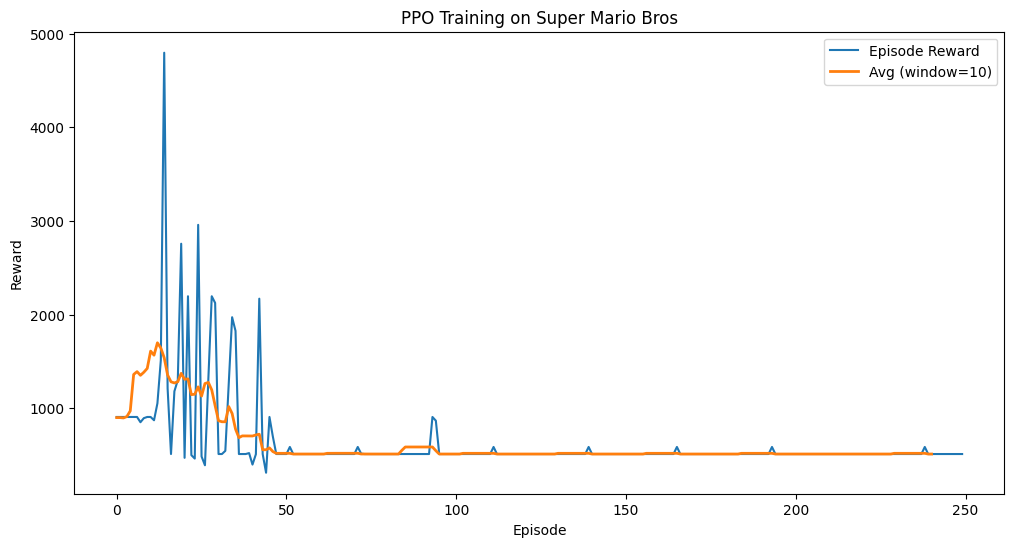

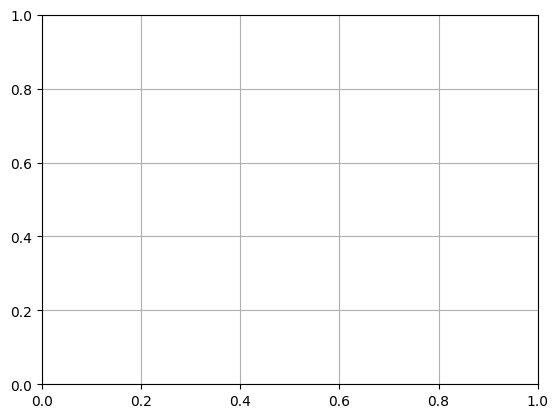

In [10]:
# Imports necesarios
import numpy as np
import matplotlib.pyplot as plt

# Configurar entorno con todos los wrappers necesarios
# Nota: NO usamos FrameStack aquí porque CustomFrameStack lo maneja internamente
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, RIGHT_ONLY)

# Verificar ambiente
print("\n=== VERIFICACIÓN DEL AMBIENTE ===")
test_state = env.reset()
print(f"✓ Estado shape: {test_state.shape}, dtype: {test_state.dtype}")
test_result = env.step(0)
print(f"✓ env.step() devuelve {len(test_result)} valores")
print(f"✓ Action space: {env.action_space.n} acciones")
print("=== FIN VERIFICACIÓN ===\n")

print("✓ Entorno configurado correctamente (sin wrappers de preprocesamiento)")

# Entrenamiento
num_episodes = 250
total_rewards = train_ppo(
    env,
    model,
    num_episodes=num_episodes,
    rollout_steps=2048,
    num_epochs=4,
    batch_size=128,
    gamma=0.99,
    gae_lambda=0.95,
    learning_rate=3e-4,
    clip_ratio=0.2,
    entropy_coef=0.01,  # Valor estándar para PPO
    value_coef=0.5,
    device=device,
    checkpoint_freq=10,
    checkpoint_path="mario_ppo_checkpoint.pt"
)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(total_rewards, label='Episode Reward')
plt.plot(np.convolve(total_rewards, np.ones(10)/10, mode='valid'), label='Avg (window=10)', linewidth=2)

plt.xlabel('Episode')
print(f"Last 10 episodes avg: {np.mean(total_rewards[-10:]):.2f}")

plt.ylabel('Reward')
print(f"Max reward: {max(total_rewards)}")

plt.title('PPO Training on Super Mario Bros')

plt.legend()
plt.show()
plt.grid()

## Inicio del Entrenamiento

A continuación entrenaremos el modelo con PPO. Parámetros clave:
- **num_episodes=100**: 100 episodios (ajusta según necesidad)
- **rollout_steps=2048**: Recolectar ~2000 pasos antes de actualizar
- **num_epochs=4**: Reusar datos 4 veces para cada actualización
- **batch_size=64**: Tamaño de mini-batch
- **clip_ratio=0.2**: PPO clipping (mantiene cambios de política pequeños)

**En Kaggle**: Si tienes tiempo limitado, puedes reducir `num_episodes` o `rollout_steps`.

El modelo guardará checkpoints automáticamente.

In [11]:
"""
=== INFERENCIA: USAR EL MODELO ENTRENADO ===

Aquí jugamos episodios usando la política aprendida.
Usamos acciones deterministas (argmax) para aprovechar lo aprendido.
"""

def play_episode(env, model, device="cpu", max_steps=1000):
    """
    Juega un episodio usando la política aprendida
    
    Args:
        env: Ambiente SuperMario
        model: Modelo PPO Actor-Critic
        device: CPU o CUDA
        max_steps: Máximo de pasos por episodio
    
    Returns:
        total_reward: Recompensa total acumulada
        steps: Número de pasos ejecutados
    """
    model.eval()
    state = env.reset()
    
    # Inicializar frame stack
    frame_stack = CustomFrameStack(k=4)
    stacked_state = frame_stack.reset(state)
    
    total_reward = 0
    done = False
    steps = 0
    hidden_state = None
    
    while not done and steps < max_steps:
        # Convertir a batch: (1, 1, 4, 84, 84)
        state_batch = stacked_state.unsqueeze(0).unsqueeze(0).to(device)
        
        with torch.no_grad():
            action_logits, _, hidden_state = model(state_batch, hidden_state)
            # Usar acción determinista (greedy): la de mayor probabilidad
            action = action_logits.argmax(dim=-1)
        
        next_state, reward, done, info = env.step(action.item())
        
        # Stack frames
        stacked_state = frame_stack.push(next_state)
        
        total_reward += reward
        steps += 1
    
    model.train()
    return total_reward, steps

# ===== TESTING =====
print("Testing trained model...")
print("Ejecutando 5 episodios de prueba...\n")

test_rewards = []
test_steps = []

for i in range(5):
    reward, steps = play_episode(env, model, device=device, max_steps=1000)
    test_rewards.append(reward)
    test_steps.append(steps)
    print(f"Episodio {i+1}: Reward = {reward:7.2f} | Steps = {steps:4d}")

print(f"\n{'='*50}")
print(f"Average reward: {np.mean(test_rewards):.2f} ± {np.std(test_rewards):.2f}")
print(f"Max reward: {max(test_rewards):.2f}")
print(f"Min reward: {min(test_rewards):.2f}")
print(f"Average steps: {np.mean(test_steps):.0f}")
print(f"{'='*50}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Testing trained model...
Ejecutando 5 episodios de prueba...

Episodio 1: Reward =  680.00 | Steps =  481
Episodio 2: Reward =  680.00 | Steps =  481
Episodio 3: Reward =  680.00 | Steps =  481
Episodio 4: Reward =  680.00 | Steps =  481
Episodio 5: Reward =  680.00 | Steps =  481

Average reward: 680.00 ± 0.00
Max reward: 680.00
Min reward: 680.00
Average steps: 481


## Conclusiones y Mejoras Implementadas

### ✅ Correcciones realizadas:

1. **Preprocesamiento de imágenes**
   - Convertir a escala de grises
   - Normalizar a [0, 1]
   - Redimensionar a 84×84

2. **Frame Stacking correcto**
   - 4 frames apilados: `(4, 84, 84)`
   - La LSTM realmente recibe secuencias temporales

3. **Dimensiones fijas**
   - Estado: `(4, 84, 84)`
   - Batch de estados: `(B, 1, 4, 84, 84)` para LSTM

4. **Hidden state persistente**
   - Se mantiene entre pasos del episodio
   - Permite memoria a través de la secuencia

5. **Mejor logging y checkpoints**
   - Información clara del progreso
   - Guardado automático cada N episodios

### 🎯 Ventajas PPO + LSTM vs DQN:
- **Convergencia más rápida**: PPO necesita menos samples que DQN
- **Más estable**: Policy gradient + clipping evita cambios abruptos
- **Memoria temporal**: LSTM captura dependencias, no solo estado actual
- **On-policy**: Usa datos recientes y relevantes

### 📊 Esperado en entrenamiento:
- Primeros episodios: rewards muy bajos (0-500)
- Episodios 20-50: Empieza a aprender (500-2000)
- Episodios 50+: Debería mejorar significativamente (>2000)

### 💾 Checkpoint system:
- Automático cada 10 episodios
- Puede reanudar entrenamiento sin perder progreso
- Archivo: `mario_ppo_checkpoint.pt`